In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
COVID_ = pd.read_csv('covid_19_data.csv')
COVID = COVID_.copy()
COVID_['Data']= pd.to_datetime(COVID_['ObservationDate']).dt.date
COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date

In [3]:
COVID = COVID.groupby(['Data','Country/Region'])['Confirmed','Deaths','Recovered'].sum()

C:\Users\alex0\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [4]:
COVID

Confirmed  Deaths  Recovered
Data       Country/Region                                  
2020-01-22 Hong Kong                 0.0     0.0        0.0
           Japan                     2.0     0.0        0.0
           Macau                     1.0     0.0        0.0
           Mainland China          547.0    17.0       28.0
           South Korea               1.0     0.0        0.0
...                                  ...     ...        ...
2020-04-11 West Bank and Gaza      268.0     2.0       57.0
           Western Sahara            4.0     0.0        0.0
           Yemen                     1.0     0.0        0.0
           Zambia                   40.0     2.0       28.0
           Zimbabwe                 14.0     3.0        0.0

[7548 rows x 3 columns]

### EDA

In [5]:
rus_data = COVID.loc[COVID.index.get_level_values('Country/Region')=='Russia', ['Confirmed','Deaths','Recovered']]

In [6]:
rus_data.index = pd.to_datetime(rus_data.index.droplevel(1))

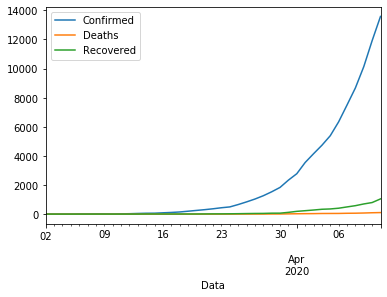

In [7]:
rus_data.loc[(rus_data.index.get_level_values('Data') > pd.to_datetime('2020-03-01')), ['Confirmed','Deaths','Recovered']].plot()
plt.show()

Посмотрим на первые разности прироста заболевших

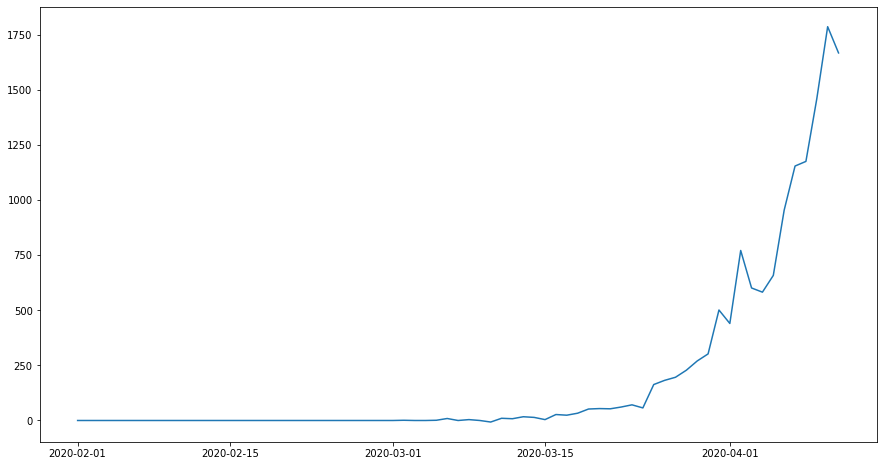

In [8]:
rus_data['diff1'] = rus_data['Confirmed'].diff(1)
plt.figure(figsize=(15, 8))
plt.plot(rus_data['diff1'])
plt.show()

Сделаем сглаживание для разностей 

Text(0.5, 1.0, 'COVID_19 RUS')

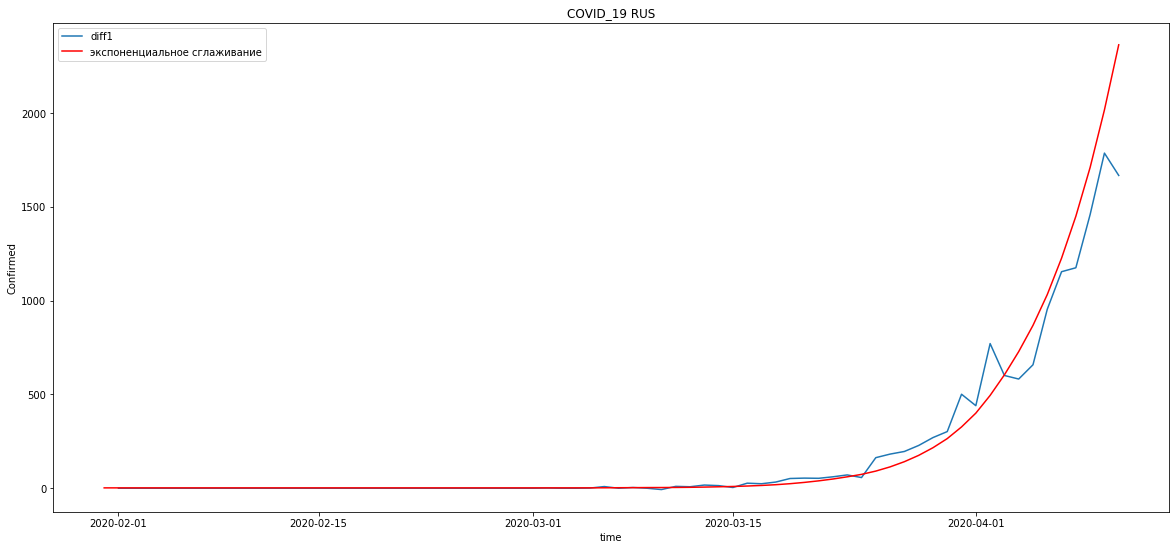

In [46]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

N2 = 24*7

exp_1 = exponential_smoothing(rus_data['Confirmed'], 0.03)

plt.figure(figsize=(20, 9))
plt.plot(rus_data.index, rus_data['diff1'], label='diff1')

plt.plot(rus_data.index, exp_1, color = 'red', label="экспоненциальное сглаживание")
plt.xlabel('time')
plt.ylabel('Confirmed')
plt.legend()
plt.title('COVID_19 RUS')

### Формирование признаков

In [47]:
df = pd.DataFrame(exp_1, index=rus_data.index)

In [48]:
 # добавим историю на глубину 5 измерения от текущего (р=5)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df['t3']=0
df.iloc[4:,4]=df.iloc[:-4,0].values
df['t4']=0
df.iloc[5:,5]=df.iloc[:-5,0].values
df.fillna(0)

df['exp_0_01'] = exponential_smoothing(df[0], 0.05)

# добавим первые разности
df['diff1'] = 0
df['diff1'] = df[0].diff(1)
df['diff1'].fillna(0, inplace=True)

In [49]:
df

,0,t,t1,t2,t3,t4,exp_0_01,diff1
Data,,,,,,,,
2020-01-31,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
2020-02-01,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
2020-02-02,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000
2020-02-03,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,2.000000,0.000000
2020-02-04,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...
2020-04-07,1226.157304,1032.213715,867.962593,728.136694,604.336798,494.708039,288.864171,193.943589
2020-04-08,1449.532585,1226.157304,1032.213715,867.962593,728.136694,604.336798,346.897591,223.375281
2020-04-09,1709.976607,1449.532585,1226.157304,1032.213715,867.962593,728.136694,415.051542,260.444022


### Делим данные

In [91]:
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), data.loc[data.index > split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

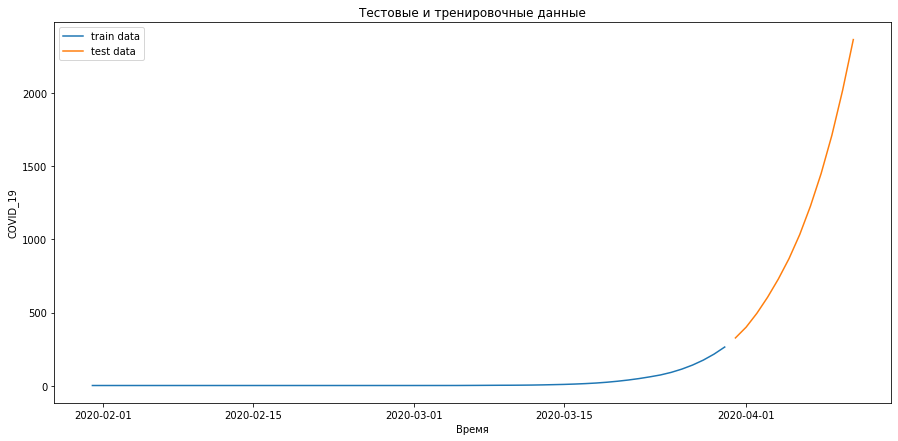

In [92]:
train, test = split_data(df, '2020-03-30')

X_train = train.iloc[:-1,:]
y_train = train[0].values[1:]
X_test = test.iloc[:-1,:]
y_test = test[0].values[1:]


plt.figure( figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('COVID_19')
plt.plot(train.index, train[df.columns[0]], label='train data')
plt.plot(test.index, test[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [93]:
# не знаю почему на графике пропуск, данные разбились верно

__Построим две модели, с глубиной прогноза h=1 и h =10__

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [95]:
model = LinearRegression()
model.fit(X_train, y_train) 

X_test_pred = model.predict(X_test)

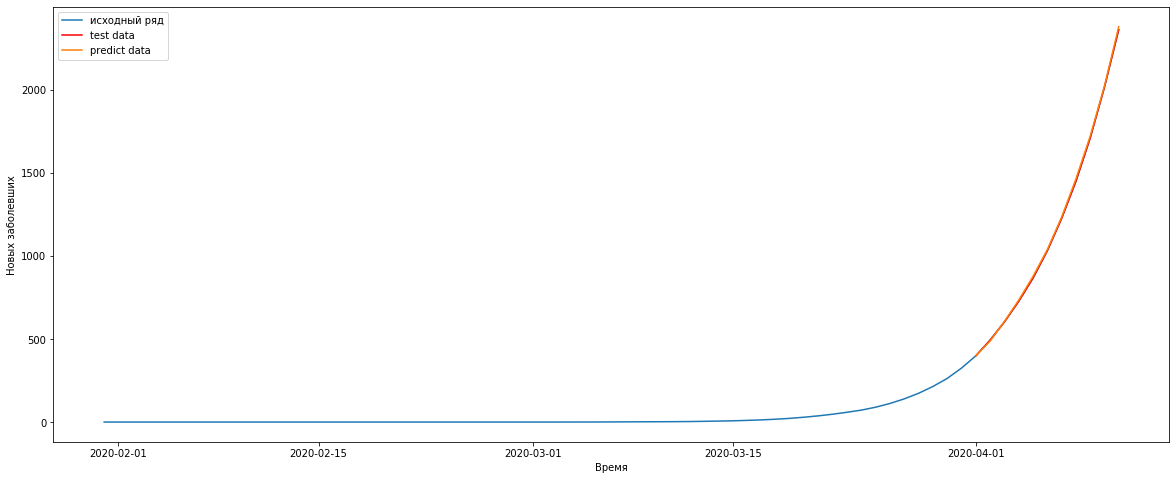

ошибка :   0.747010187717174 %


In [96]:
plt.figure( figsize=(20, 8))
plt.xlabel('Время')
plt.ylabel('Новых заболевших')
plt.plot(df[0], label='исходный ряд')
plt.plot(test.index[1:],y_test, label='test data', color='r')
plt.plot(test.index[1:],X_test_pred, label='predict data')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка :  ', er_g, '%')

Модель отработала неплохо

Теперь построим модель с h=10

In [97]:
h = 10
X_train = train.iloc[:-h,:]
y_train = train[0].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[0].values[h:]

model.fit(X_train, y_train) 
X_test_pred = model.predict(X_test)

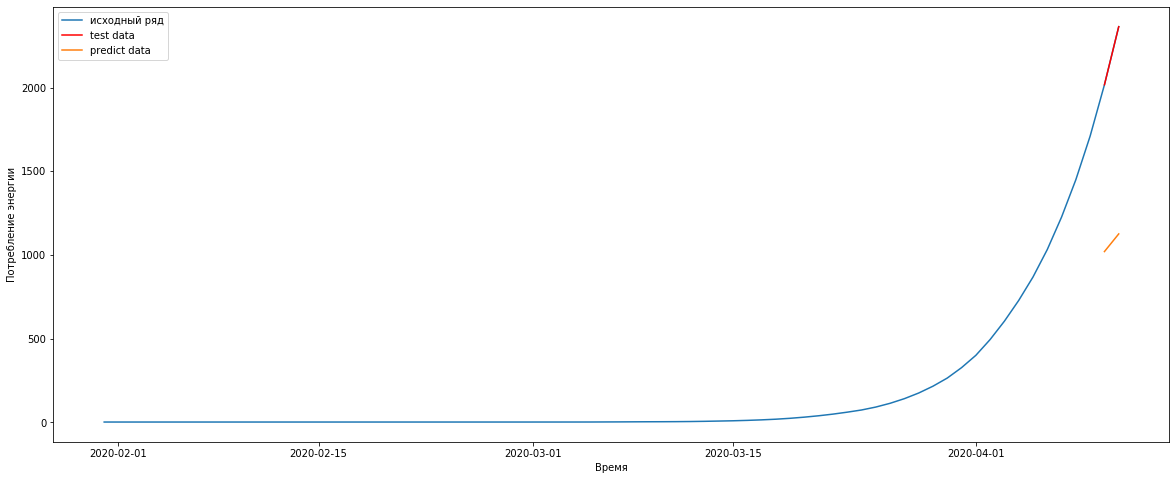

ошибка :   50.88864596645636 %


In [98]:
plt.figure( figsize=(20, 8))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(df[0], label='исходный ряд')
plt.plot(test.index[h:],y_test, label='test data', color='r')
plt.plot(test.index[h:],X_test_pred, label='predict data')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка :  ', er_g, '%')

Как и ожидалось, модель с h=10 отработала намного хуже предыдущей.